2025-07-27 05:48:00,568 - INFO - Successfully imported feature engineering module
2025-07-27 05:48:00,568 - INFO - Feature selector initialized successfully
2025-07-27 05:48:00,568 - INFO - 
Data paths verification:
2025-07-27 05:48:00,584 - INFO - Training data exists: True
2025-07-27 05:48:00,586 - INFO - Validation data exists: Validation path not provided
2025-07-27 05:48:00,593 - INFO - Test data exists: True
2025-07-27 05:48:00,596 - INFO - 
Starting leakage-proof feature engineering pipeline...
2025-07-27 05:48:00,607 - INFO - Starting leakage-proof feature engineering pipeline...
2025-07-27 05:48:00,692 - INFO - Loaded training data from C:\Users\Nanaba\Desktop\football_player_scouting_ml\data\processed\v20250724\fifa_players_train_processed.feather
2025-07-27 05:48:00,724 - INFO - Loaded test data from C:\Users\Nanaba\Desktop\football_player_scouting_ml\data\processed\v20250724\fifa_players_test_processed.feather
2025-07-27 05:48:00,724 - INFO - 3163/27377 players marked as pr

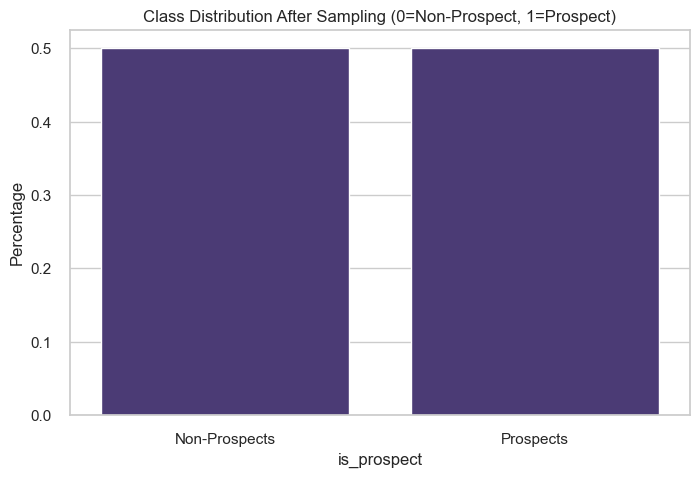

2025-07-27 05:48:51,207 - INFO - 
Leakage-Proof Engineered Features Overview:


,num__skill_index,num__attack_defense_ratio,num__value_efficiency,num__value_eur,num__defense_index,num__weight_kg,num__physical_ratio,num__height_cm,remainder__wage_eur,num__international_reputation,...,num__defending,remainder__power_strength,remainder__power_stamina,remainder__goalkeeping_score,remainder__wage_ratio,remainder__movement_balance,remainder__defending_standing_tackle,remainder__player_positions_GK,remainder__player_positions_CB,is_prospect
0,1.148978,0.206463,-0.301145,0.411065,0.402616,0.497610,0.509916,0.495493,7000.0,0.0,...,-0.190233,70.0,82.0,8.45,8.750000,67.0,41.0,0.0,0.0,0
1,0.476893,1.039322,-0.277490,0.077848,-1.042068,-0.113845,0.042864,0.495493,500.0,0.0,...,-1.413118,69.0,57.0,11.15,42.000000,58.0,17.0,0.0,0.0,1
2,0.290203,1.687291,-0.201713,-0.255369,-1.668098,-0.266709,-0.120223,0.338528,700.0,0.0,...,-1.752809,64.0,51.0,8.75,37.058823,61.0,16.0,0.0,0.0,1


2025-07-27 05:48:51,252 - INFO - 
Datasets processed:
2025-07-27 05:48:51,252 - INFO - - Training: 48428 players
2025-07-27 05:48:51,252 - INFO - - Test: 9126 players
2025-07-27 05:48:54,666 - INFO - 
Modeling data saved to C:\Users\Nanaba\Desktop\football_player_scouting_ml\data\leakproof_features\modeling_data.csv
2025-07-27 05:48:54,666 - INFO - 
Selected Features (Leakage-Proof):
2025-07-27 05:48:54,672 - INFO - ['remainder__skill_progression', 'remainder__dev_curve_score', 'remainder__potential_growth', 'remainder__mental_composite', 'remainder__technical_composite', 'remainder__playmaking_score', 'remainder__mentality_vision', 'remainder__value_efficiency', 'remainder__skill_ball_control', 'remainder__attacking_score', 'num__skill_index', 'num__dribbling', 'num__skill_moves', 'remainder__mentality_composure', 'remainder__attacking_finishing', 'num__passing', 'num__value_eur', 'num__shooting', 'num__attack_defense_ratio', 'remainder__skill_long_passing', 'num__defense_index', 'num

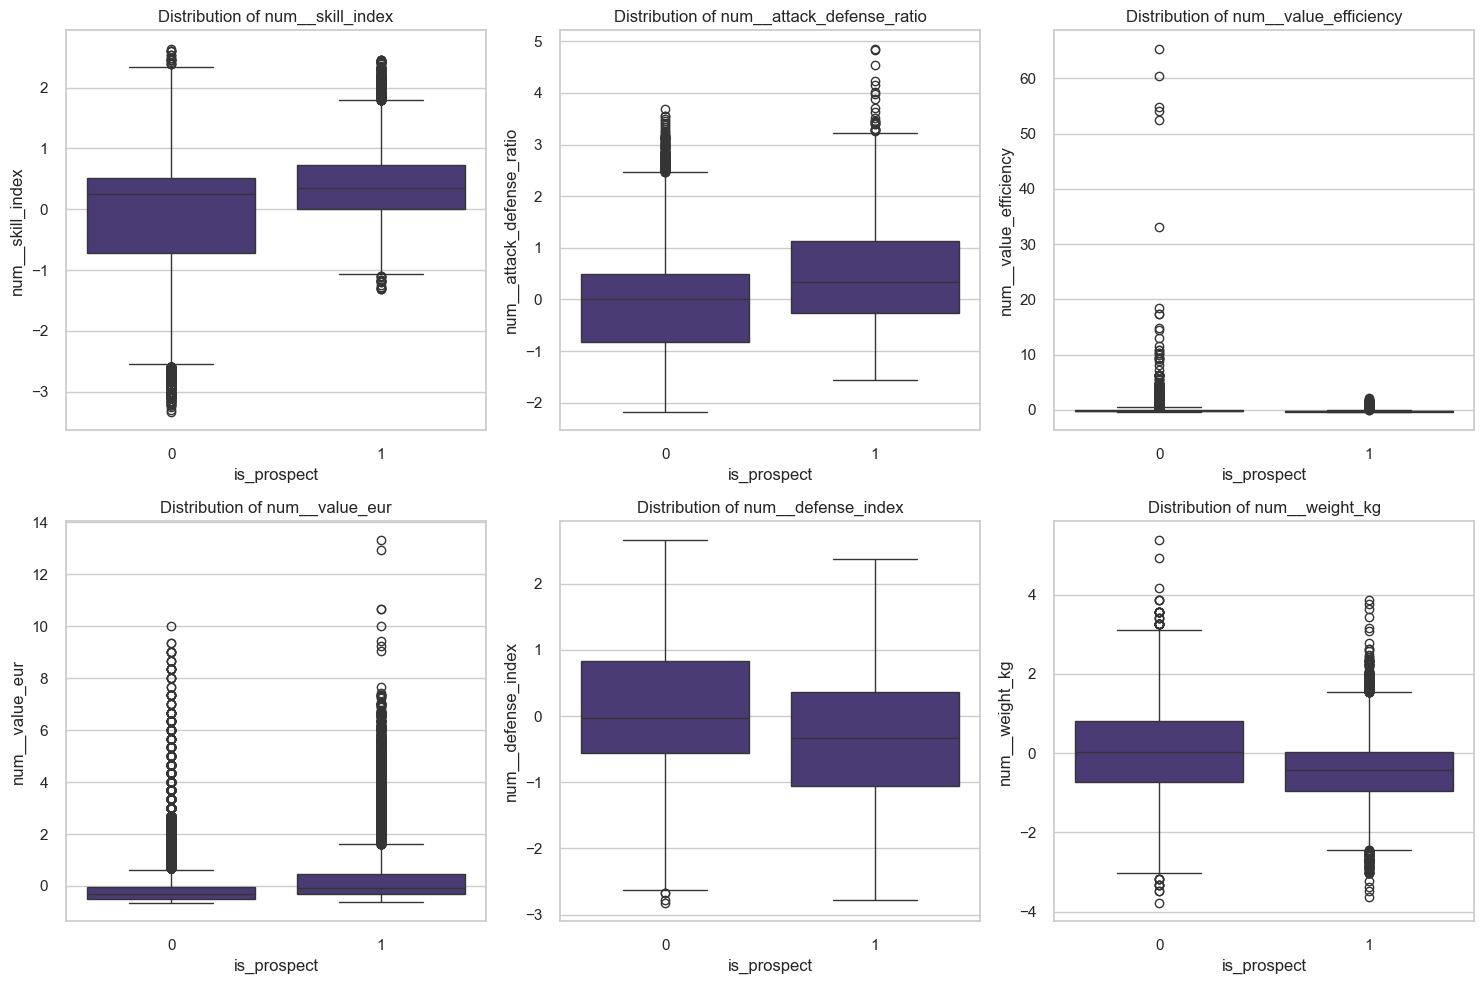

2025-07-27 05:48:57,138 - INFO - 
Notebook execution completed!


In [1]:
# %% [markdown]
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import logging
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import StratifiedKFold

# Visualization setup
plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid", palette="viridis")
%matplotlib inline

# %%
# Set up paths - MODIFY TO MATCH YOUR STRUCTURE
PROJECT_ROOT = Path(r"C:\Users\Nanaba\Desktop\football_player_scouting_ml")
DATA_DIR = PROJECT_ROOT / 'data'
SRC_DIR = PROJECT_ROOT / 'src'

# Add src directory to Python path
sys.path.insert(0, str(SRC_DIR))

# Create required directories
(DATA_DIR / 'leakproof_features').mkdir(parents=True, exist_ok=True)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(PROJECT_ROOT / 'feature_engineering.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# %%
# Import feature engineering module
try:
    from feature_selection import run_balanced_pipeline, BalancedFeatureSelector
    logger.info("Successfully imported feature engineering module")
    
    # Test initialization
    test_selector = BalancedFeatureSelector()
    logger.info("Feature selector initialized successfully")
except Exception as e:
    logger.error(f"Error during import: {e}")
    logger.error(f"Please ensure feature_selection.py exists in: {SRC_DIR}")

# %%
# Pipeline configuration
pipeline_config = {
    "target_column": "is_prospect",
    "protected_features": [
        "height_cm", "weight_kg",  # remove "age"
        "value_eur", "wage_eur", "international_reputation"
    ],
    "numeric_cols": [
        "height_cm", "weight_kg",  # remove "age"
        "value_eur", "international_reputation",
        "weak_foot", "skill_moves", "pace", "shooting",
        "passing", "dribbling", "defending", "physic"
    ],
    "exclude_cols": [
        "sofifa_id", "short_name", "player_positions",
        "long_name", "year", "potential", "overall", "age", "age_squared"
    ],
    "target_feature_count": 35,
    "min_features_to_select": 25,
    "random_state": 42,
    "sampling_strategy": "auto",
    "smote_k_neighbors": 5,
    "target_ratio": 0.33,
    "prospect_max_age": 21,
    "oversample_ratio": 1.0,

    "prospect_threshold": 10,
    "output_dir": str(DATA_DIR / 'leakproof_features')
}


# %%
# Data paths
train_path = DATA_DIR / 'processed' / 'v20250724' / 'fifa_players_train_processed.feather'
test_path = DATA_DIR / 'processed' / 'v20250724' / 'fifa_players_test_processed.feather'
val_path = None  # Optional validation path

# Verify paths
logger.info("\nData paths verification:")
logger.info(f"Training data exists: {train_path.exists()}")
logger.info(f"Validation data exists: {val_path.exists() if val_path else 'Validation path not provided'}")
logger.info(f"Test data exists: {test_path.exists()}")

# %%
# Only proceed if imports were successful and data exists
if 'run_balanced_pipeline' in globals() and train_path.exists():
    try:
        logger.info("\nStarting leakage-proof feature engineering pipeline...")
        
        results = run_balanced_pipeline(
            train_path=str(train_path),
            test_path=str(test_path) if test_path.exists() else None,
            output_dir=pipeline_config["output_dir"],
            config=pipeline_config
        )
        
        logger.info("\nPipeline completed successfully!")
        
        # Get results
        train_features = results.get('train', None)
        test_features = results.get('test', None)
        
        if train_features is None:
            raise ValueError("No 'train' data returned from pipeline. Check run_balanced_pipeline().")

        
        # Show class distribution
        logger.info("\nClass Distribution in Training Data:")
        class_dist = train_features['is_prospect'].value_counts(normalize=True)
        logger.info(class_dist)
        
        # Visualize class distribution
        plt.figure(figsize=(8, 5))
        sns.barplot(x=class_dist.index, y=class_dist.values)
        plt.title('Class Distribution After Sampling (0=Non-Prospect, 1=Prospect)')
        plt.ylabel('Percentage')
        plt.xticks([0, 1], ['Non-Prospects', 'Prospects'])
        plt.show()
        
        # Show engineered features
        logger.info("\nLeakage-Proof Engineered Features Overview:")
        display(train_features.head(3))
        
        # Show which datasets were processed
        logger.info("\nDatasets processed:")
        logger.info(f"- Training: {len(train_features)} players")
        if test_features is not None:
            logger.info(f"- Test: {len(test_features)} players")
        
        # Feature importance visualization
        importance_file = Path(pipeline_config["output_dir"]) / "feature_importance.csv"
        if importance_file.exists():
            importance_scores = pd.read_csv(importance_file, index_col=0)
            plt.figure(figsize=(12, 8))
            importance_scores.sort_values('importance', ascending=False).head(30)['importance'].plot(kind='bar')
            plt.title('Top 30 Leakage-Proof Feature Importance Scores')
            plt.ylabel('Combined Importance Score')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        
        # Save modeling-ready data
        modeling_path = Path(pipeline_config["output_dir"]) / "modeling_data.csv"
        train_features.to_csv(modeling_path, index=False)
        logger.info(f"\nModeling data saved to {modeling_path}")
        
        # Show selected features
        selected_features_file = Path(pipeline_config["output_dir"]) / "selected_features.txt"
        if selected_features_file.exists():
            with open(selected_features_file, 'r') as f:
                selected_features = f.read().splitlines()
            logger.info("\nSelected Features (Leakage-Proof):")
            logger.info(selected_features)
        
        # Additional visualizations
        logger.info("\nFeature Distributions by Prospect Status:")
        plt.figure(figsize=(15, 10))
        for i, col in enumerate(train_features.drop('is_prospect', axis=1).columns[:6]):
            plt.subplot(2, 3, i+1)
            sns.boxplot(x='is_prospect', y=col, data=train_features)
            plt.title(f'Distribution of {col}')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        logger.error(f"\nPipeline failed: {e}")
        logger.error(f"Check detailed logs in: {PROJECT_ROOT / 'feature_engineering.log'}")
else:
    logger.error("\nCannot run pipeline without required imports or missing data")

logger.info("\nNotebook execution completed!")